Building an Image Classifier using CNN

#Setup

In [2]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
np.random.seed(42)
import matplotlib as mpl
import matplotlib.pyplot as plt

# our imports
import kagglehub
import os
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
path = kagglehub.dataset_download("alessiocorrado99/animals10")

# using 128x128 for our scratch model
train_ds_128 = image_dataset_from_directory(f"{path}/raw-img", validation_split=0.2,subset="training",seed=67,image_size=(128, 128),batch_size=32)
test_ds_128 = image_dataset_from_directory(f"{path}/raw-img",validation_split=0.2,subset="validation",seed=67,image_size=(128, 128),batch_size=32)

# using 224x224 for our transfer model since 224 is the standard for pretrained models
train_ds_224 = image_dataset_from_directory(f"{path}/raw-img", validation_split=0.2,subset="training",seed=67,image_size=(224, 224),batch_size=32)
test_ds_224 = image_dataset_from_directory(f"{path}/raw-img",validation_split=0.2,subset="validation",seed=67,image_size=(224, 224),batch_size=32)

Using Colab cache for faster access to the 'animals10' dataset.
Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


# Build a neural network model

Model from Scratch

In [4]:
scratch = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),

    # need to change the images so that the model does not memorize them
    tf.keras.layers.Rescaling(1./255), # normalize the image for model to learn efficiently
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),

    tf.keras.layers.Conv2D(32, 3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, 3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(256, 3, padding="same"), # enough layers for model to find patterns
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

Model w/ Transfer Learning

In [19]:
base_model = tf.keras.applications.EfficientNetB1(input_shape=(224, 224, 3),include_top=False,weights="imagenet")
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False # make last layer trainable to fine tune base model for animals10

transfer = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input), # also normalizes the images but specifically for imagenet
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation="softmax")
])



In [6]:
scratch.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 128, 128, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             

 Total params: 424,522 (1.62 MB)

 Trainable params: 423,562 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
transfer.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 3)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,802 (7.04 KB)

 Trainable params: 1,802 (7.04 KB)

 Non-trainable params: 0 (0.00 B)

#compiling the model:


In [8]:
scratch.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(3e-4),
              metrics=["accuracy"])

In [20]:
transfer.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(1e-5), # smaller learning rate since the model already has pretrained weights
              metrics=["accuracy"])

# training neural network model:


In [10]:
early_stop = tf.keras.callbacks.EarlyStopping( # stop early if loss doesnt lower
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint( # keep the best acc model by the end
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [11]:
history_s = scratch.fit(train_ds_128, batch_size = 32, epochs=100, validation_data=test_ds_128, callbacks=[early_stop])

Epoch 1/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.2777 - loss: 2.0750 - val_accuracy: 0.3809 - val_loss: 1.8285
Epoch 2/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.4252 - loss: 1.6504 - val_accuracy: 0.3240 - val_loss: 1.8653
Epoch 3/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4784 - loss: 1.4983 - val_accuracy: 0.2166 - val_loss: 2.6556
Epoch 4/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5230 - loss: 1.3908 - val_accuracy: 0.3400 - val_loss: 1.8509
Epoch 5/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5442 - loss: 1.3241 - val_accuracy: 0.4984 - val_loss: 1.4800
Epoch 6/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5646 - loss: 1.2741 - val_accuracy: 0.4762 - val_loss: 1.5415
Epoch 7/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5850 - loss: 1.2075 - val_accuracy: 0.4793 - val_loss: 1.5128
Epoch 8/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5946 - loss: 1

In [21]:
history_t = transfer.fit(train_ds_224, batch_size = 32, epochs=5, validation_data=test_ds_224)

Epoch 1/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 48s 47ms/step - accuracy: 0.4296 - loss: 1.8257 - val_accuracy: 0.9295 - val_loss: 0.6021
Epoch 2/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.8917 - loss: 0.5822 - val_accuracy: 0.9610 - val_loss: 0.2453
Epoch 3/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.9299 - loss: 0.3245 - val_accuracy: 0.9683 - val_loss: 0.1658
Epoch 4/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.9392 - loss: 0.2540 - val_accuracy: 0.9710 - val_loss: 0.1358
Epoch 5/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.9468 - loss: 0.2172 - val_accuracy: 0.9738 - val_loss: 0.1215


#Evaluation



In [22]:
score_s = scratch.evaluate(test_ds_128)

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7070 - loss: 0.8865


In [23]:
score_t = transfer.evaluate(test_ds_224)

164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9764 - loss: 0.1133


In [24]:
print('Total loss on Testing Set w/ Scratch Model:', score_s[0])
print('Accuracy of Testing Set: w/ Scratch Model', score_s[1])

Total loss on Testing Set w/ Scratch Model: 0.9078558683395386
Accuracy of Testing Set: w/ Scratch Model 0.7002865076065063


In [25]:
print('Total loss on Testing Set w/ Transfer Model:', score_t[0])
print('Accuracy of Testing Set: w/ Transfer Model', score_t[1])

Total loss on Testing Set w/ Transfer Model: 0.12148620188236237
Accuracy of Testing Set: w/ Transfer Model 0.973829984664917


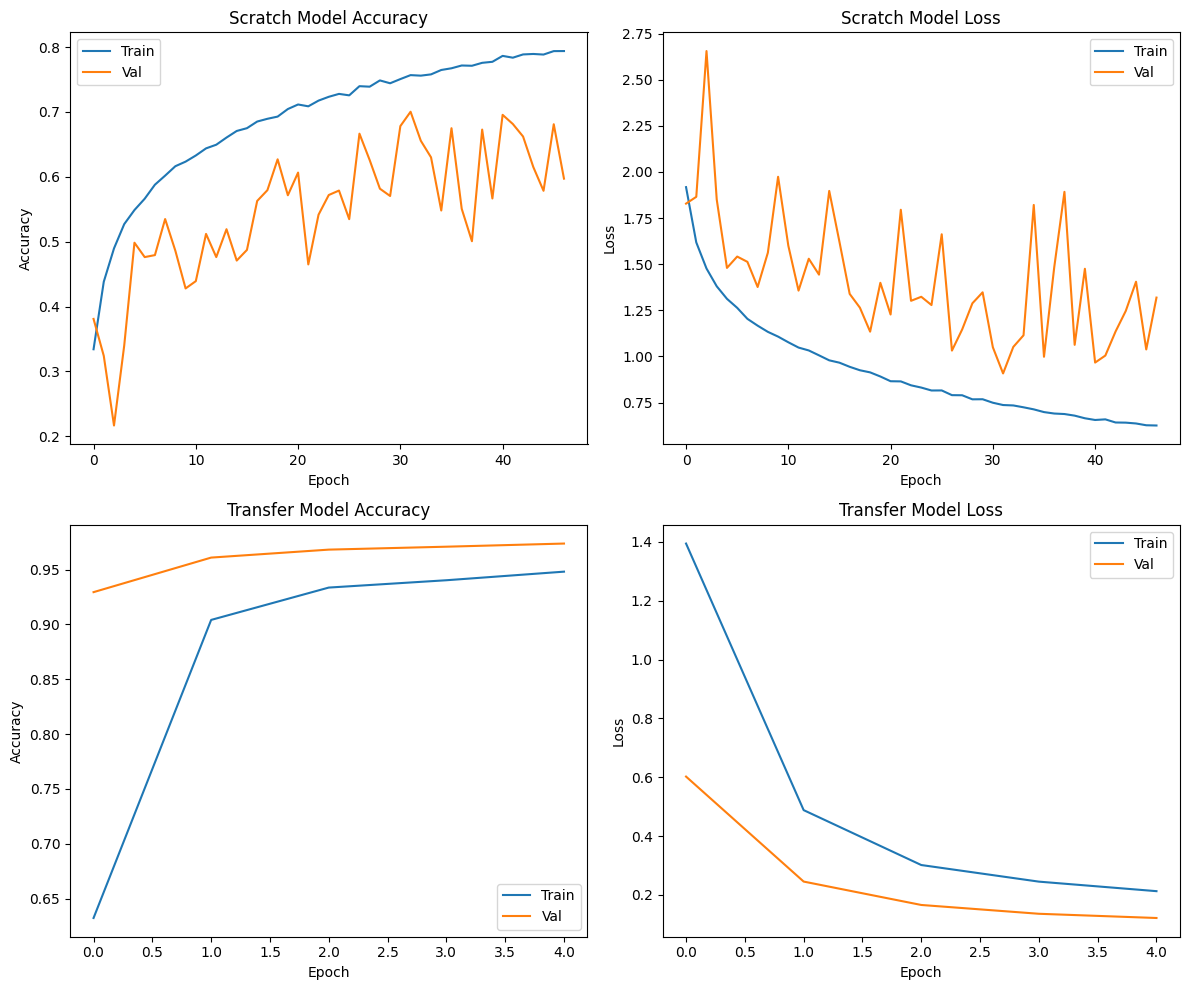

In [26]:
plt.figure(figsize=(12, 10))

# scratch
plt.subplot(2, 2, 1)
plt.plot(history_s.history['accuracy'], label='Train')
plt.plot(history_s.history['val_accuracy'], label='Val')
plt.title('Scratch Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history_s.history['loss'], label='Train')
plt.plot(history_s.history['val_loss'], label='Val')
plt.title('Scratch Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# transfer
plt.subplot(2, 2, 3)
plt.plot(history_t.history['accuracy'], label='Train')
plt.plot(history_t.history['val_accuracy'], label='Val')
plt.title('Transfer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history_t.history['loss'], label='Train')
plt.plot(history_t.history['val_loss'], label='Val')
plt.title('Transfer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Class names: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
Scratch labels: [0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8 9]
Transfer labels: [0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8 9]


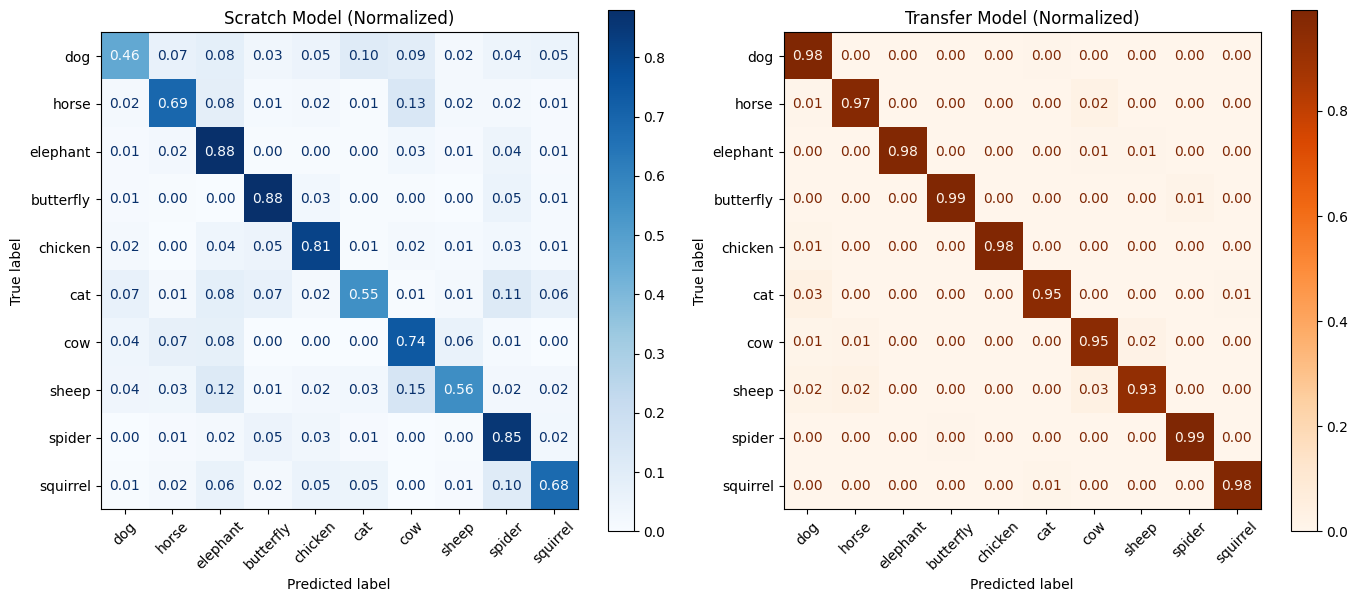

In [27]:
assert train_ds_128.class_names == train_ds_224.class_names, \
    "Class order mismatch between datasets!"

base_class_names = train_ds_128.class_names

translate = {"cane": "dog","cavallo": "horse","elefante": "elephant","farfalla": "butterfly","gallina": "chicken","gatto": "cat","mucca": "cow","pecora": "sheep","ragno": "spider","scoiattolo": "squirrel",}
class_names = [translate.get(c, c) for c in base_class_names]

def get_preds_labels(model, dataset):
    y_true, y_pred = [], []

    for x, y in dataset:
        preds = model.predict(x, verbose=0)
        y_pred.append(np.argmax(preds, axis=1))

        if y.ndim == 2:
            y_true.append(np.argmax(y.numpy(), axis=1))
        else:
            y_true.append(y.numpy())

    return np.concatenate(y_true), np.concatenate(y_pred)

y_true_s, y_pred_s = get_preds_labels(scratch, test_ds_128)
y_true_t, y_pred_t = get_preds_labels(transfer, test_ds_224)

cm_s = confusion_matrix(y_true_s, y_pred_s, normalize="true")
cm_t = confusion_matrix(y_true_t, y_pred_t, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ConfusionMatrixDisplay(cm_s, display_labels=class_names).plot(
    ax=axes[0], cmap="Blues", xticks_rotation=45, values_format=".2f"
)
axes[0].set_title("Scratch Model (Normalized)")

ConfusionMatrixDisplay(cm_t, display_labels=class_names).plot(
    ax=axes[1], cmap="Oranges", xticks_rotation=45, values_format=".2f"
)
axes[1].set_title("Transfer Model (Normalized)")

plt.tight_layout()
plt.show()

#Predicting the first three images from the test set


1.   print the predicted results of the first three images from the test set
2.   print the real label of the first three images from the test set



In [28]:
for images, labels in test_ds_128.take(1):
    X_new_s = images[:3]
    y_true_s = labels[:3]
y_proba_s = scratch.predict(X_new_s)
y_proba_s.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


array([[0.02, 0.03, 0.01, 0.09, 0.3 , 0.02, 0.06, 0.03, 0.05, 0.39],
       [0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.96, 0.  ],
       [0.06, 0.03, 0.03, 0.03, 0.03, 0.21, 0.02, 0.05, 0.27, 0.26]],
      dtype=float32)

In [29]:
for images, labels in test_ds_224.take(1):
    X_new_t = images[:3]
    y_true_t = labels[:3]
y_proba_t = transfer.predict(X_new_t)
y_proba_t.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


array([[0.  , 0.  , 0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.98, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [30]:
y_proba_s = scratch.predict(X_new_s)
y_pred_s = np.argmax(y_proba_s, axis=-1)
y_pred_s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


array([9, 8, 8])

In [31]:
y_proba_t = transfer.predict(X_new_t)
y_pred_t = np.argmax(y_proba_t, axis=-1)
y_pred_t

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


array([3, 5, 5])

In [32]:
it_class_names = train_ds_224.class_names
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "ragno": "spider", "squirrel": "scoiattolo"}
class_names = [translate.get(name, name) for name in it_class_names]
class_names

['dog',
 'horse',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'sheep',
 'spider',
 'squirrel']

In [33]:
print(np.array(class_names)[y_pred_s])
print(np.array(class_names)[y_pred_t])

['squirrel' 'spider' 'spider']
['butterfly' 'cat' 'cat']


In [34]:
print(y_true_s)
print(y_true_t)

tf.Tensor([9 8 5], shape=(3,), dtype=int32)
tf.Tensor([3 5 5], shape=(3,), dtype=int32)


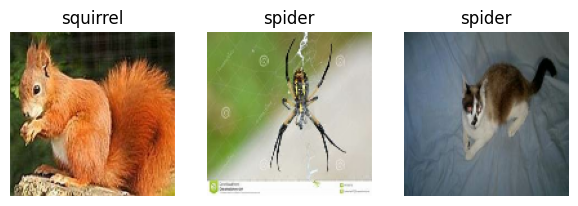

In [35]:
# scratch
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new_s):
    plt.subplot(1, 3, index + 1)

    img = image / 255.0

    plt.imshow(img)
    plt.axis('off')
    plt.title(class_names[y_pred_s[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

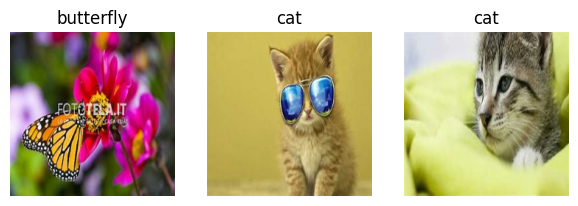

In [36]:
# transfer
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new_t):
    plt.subplot(1, 3, index + 1)

    img = image / 255.0

    plt.imshow(img)
    plt.axis('off')
    plt.title(class_names[y_pred_t[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()